# **Air Pollution Dataset Preprocessing**

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime, timedelta
import seaborn as sns

from utils import *

datasets_folder = './datasets'

## **Data Reading**

We start by reading the dataset `csv` and performing some initial column renaming and preprocessing.

In [2]:
air_pollution_dataset = os.path.join(datasets_folder,'pollution/pollution.csv')

air_pollution_df = pd.read_csv(air_pollution_dataset, sep=';')
air_pollution_df.rename(columns={
    'COD_STAZ': 'Station', 
    'AGENTE': 'Agent', 
    'DATA_INIZIO': 'Date', 
    'DATA_FINE': 'Ending_date', 
    'VALORE': 'Value', 
    'UM': 'Unit'
}, inplace=True)

air_pollution_df.drop(columns=['Ending_date'], inplace=True)
air_pollution_df=air_pollution_df.sort_values(by='Date')
air_pollution_df['Date'] = pd.to_datetime(air_pollution_df['Date'].apply(lambda x: ' '.join(x.split('T')).split('+')[0]))
air_pollution_df['Date'] = air_pollution_df['Date'].apply(lambda x: x - timedelta(minutes=x.minute)) # round to the hour
air_pollution_df = air_pollution_df.set_index('Date')
air_pollution_df['Agent'] = air_pollution_df['Agent'].apply(lambda x: x.split(' ')[0])

air_pollution_df.head(5)

,Station,Agent,Value,Unit
Date,,,,
2019-01-01,GIARDINI MARGHERITA,PM2.5,37.0,ug/m3
2019-01-01,GIARDINI MARGHERITA,PM10,50.0,ug/m3
2019-01-01,PORTA SAN FELICE,PM2.5,41.0,ug/m3
2019-01-01,VIA CHIARINI,O3,0.0,ug/m3
2019-01-01,VIA CHIARINI,NO2,20.0,ug/m3


Let's check the Unit of each agent

In [3]:
air_pollution_df.groupby([ 'Agent','Unit']).size().reset_index(name='counts').drop(columns='counts')

,Agent,Unit
0,C6H6,ug/m3
1,CO,mg/m3
2,NO,ug/m3
3,NO2,ug/m3
4,NOX,ug/m3
5,O3,ug/m3
6,PM10,ug/m3
7,PM2.5,ug/m3


...and we create a dict with a subdict for each station-agent pair, for easier accessing.

In [4]:
agents = np.unique(air_pollution_df['Agent'])
stations = np.unique(air_pollution_df['Station'])

station_dfs = {s:air_pollution_df[air_pollution_df['Station'] == s] for s in stations}

## **Data Visualization**

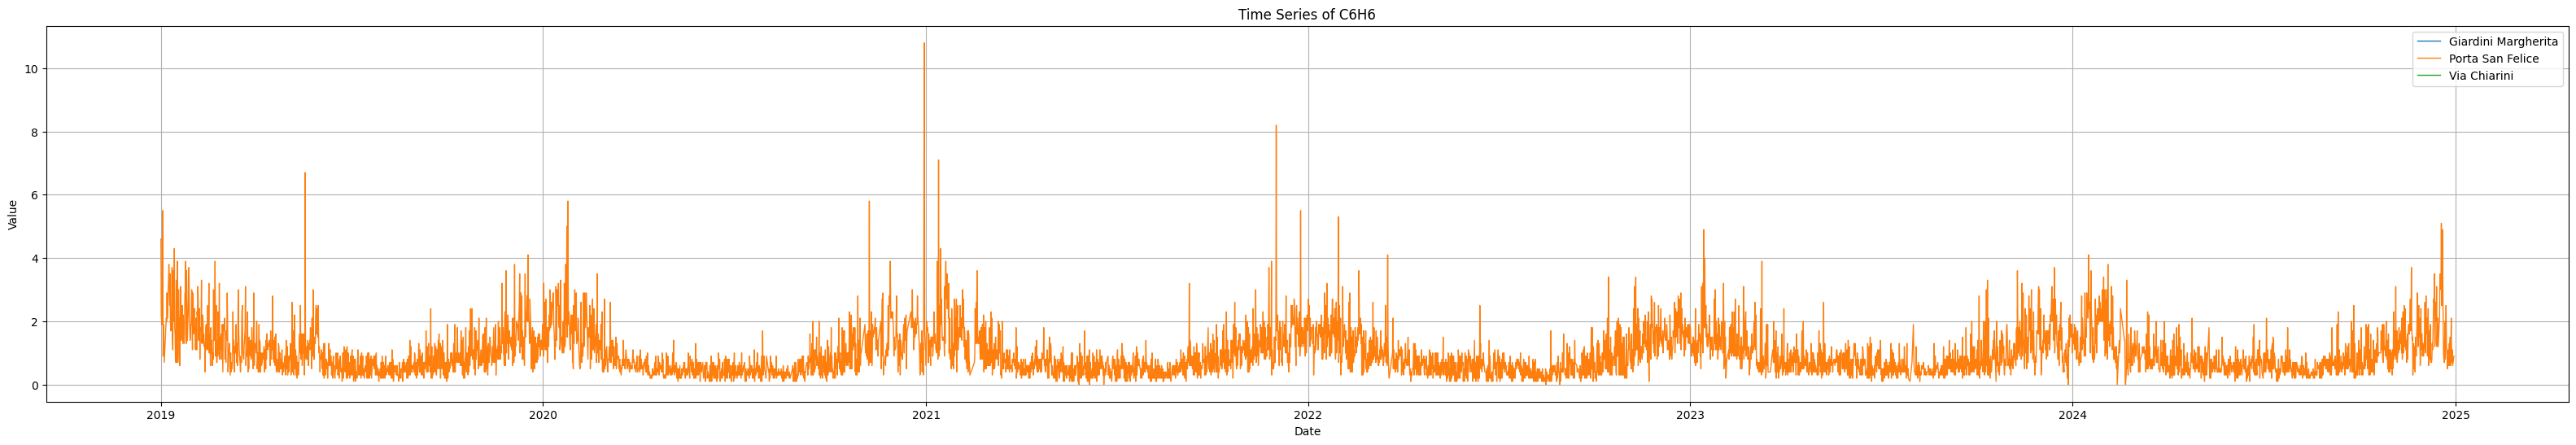

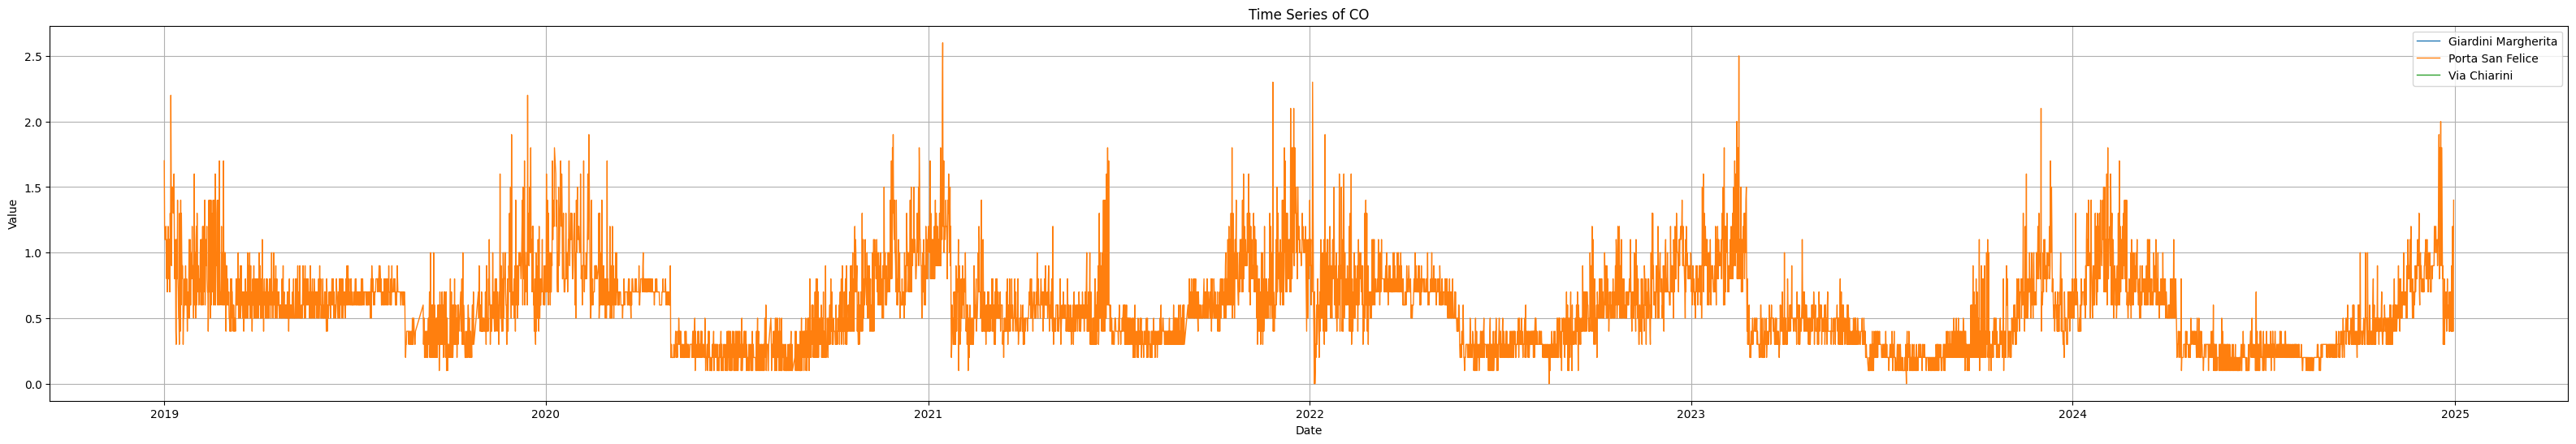

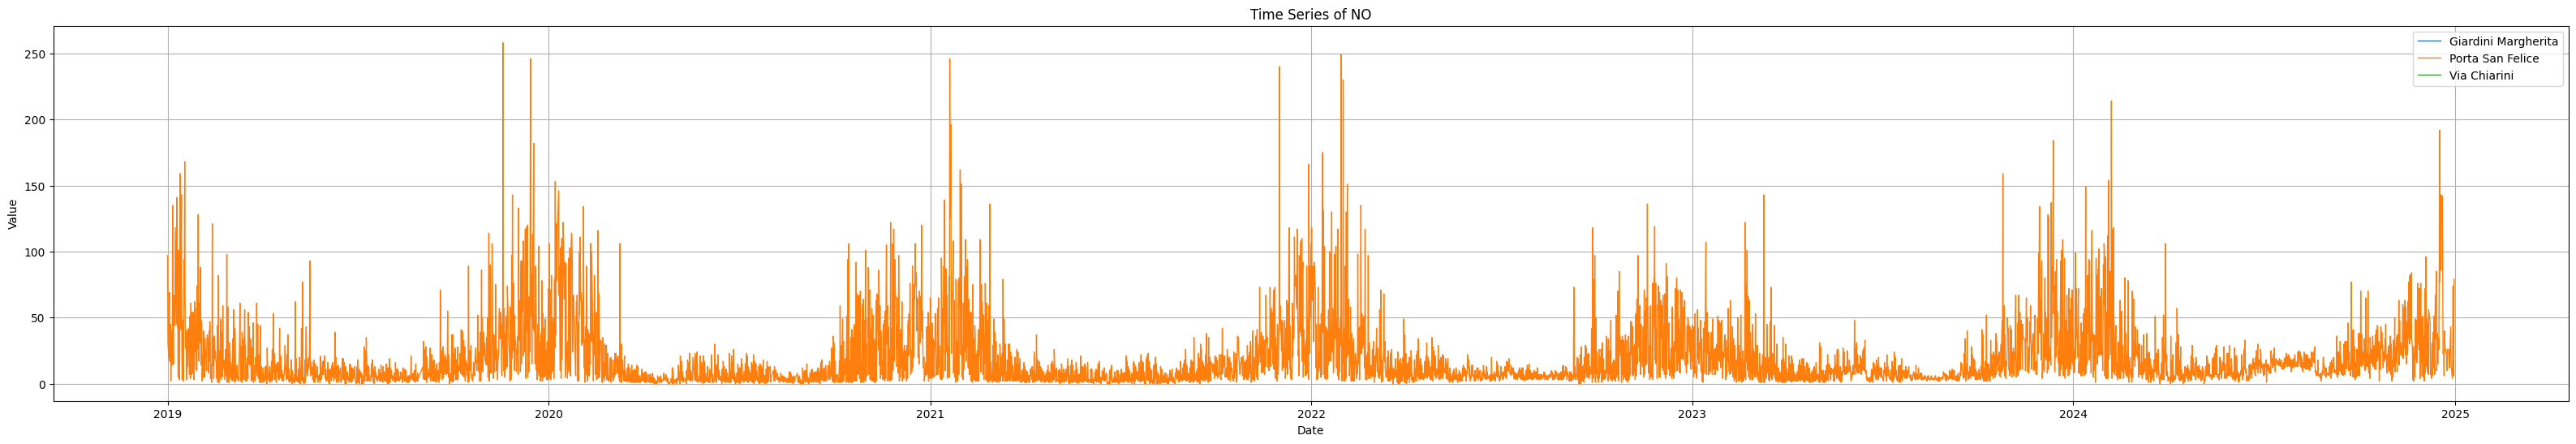

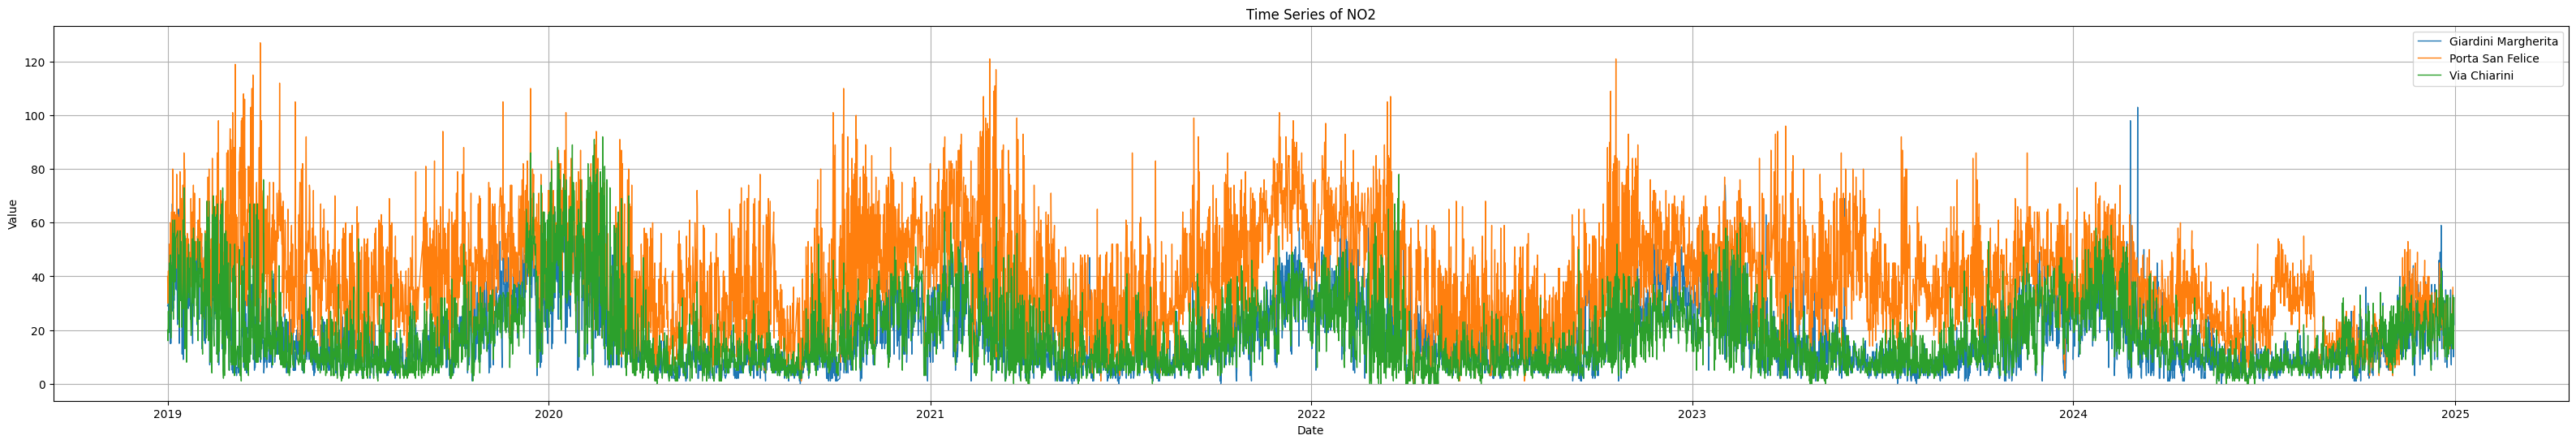

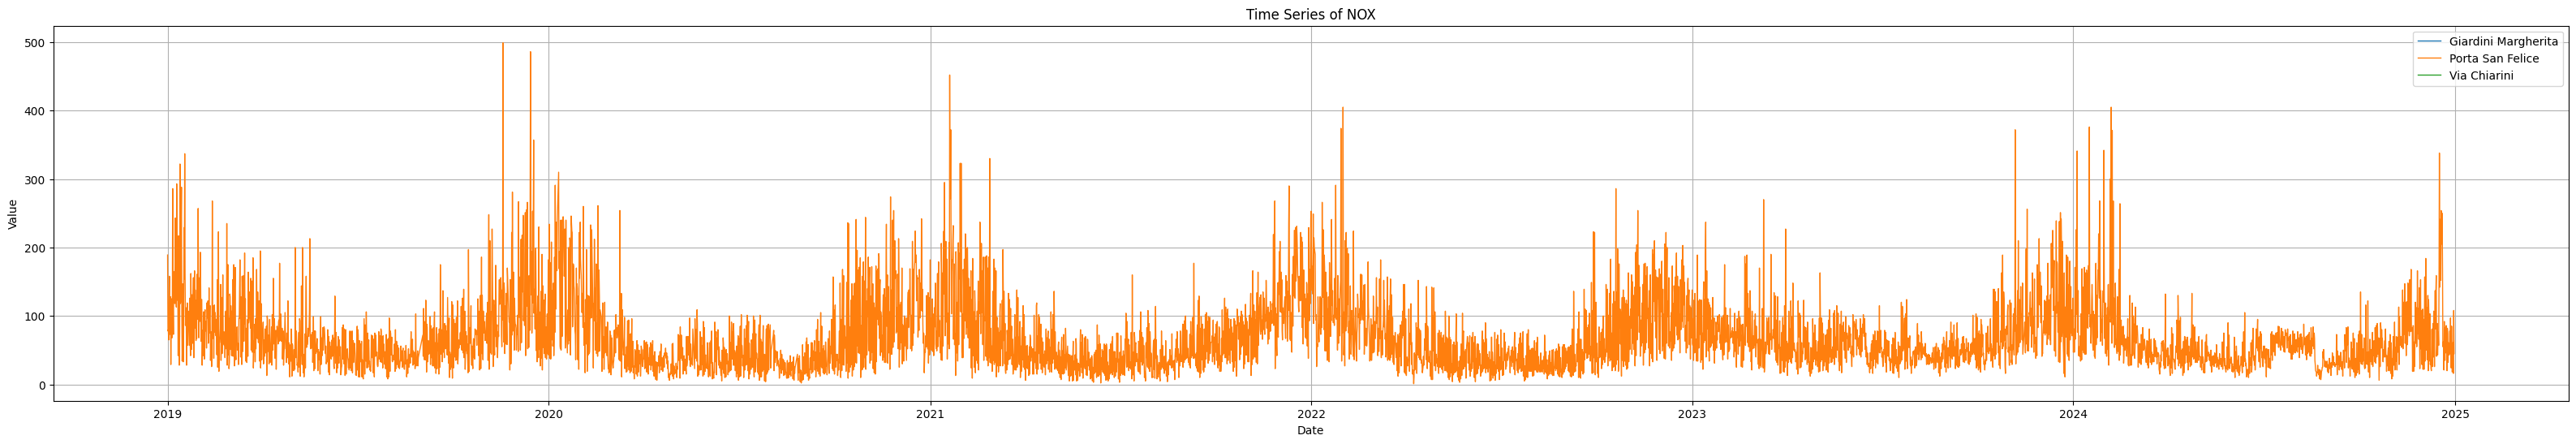

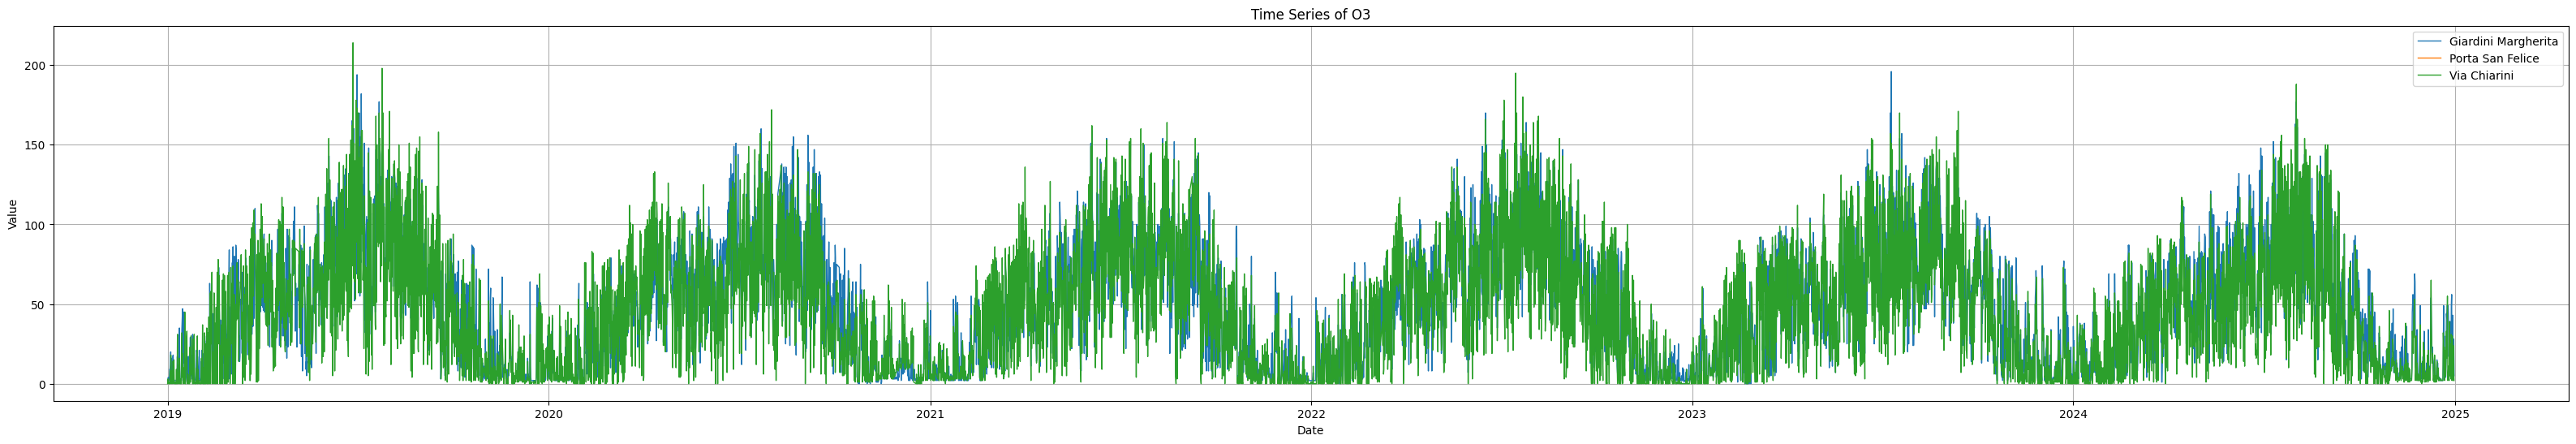

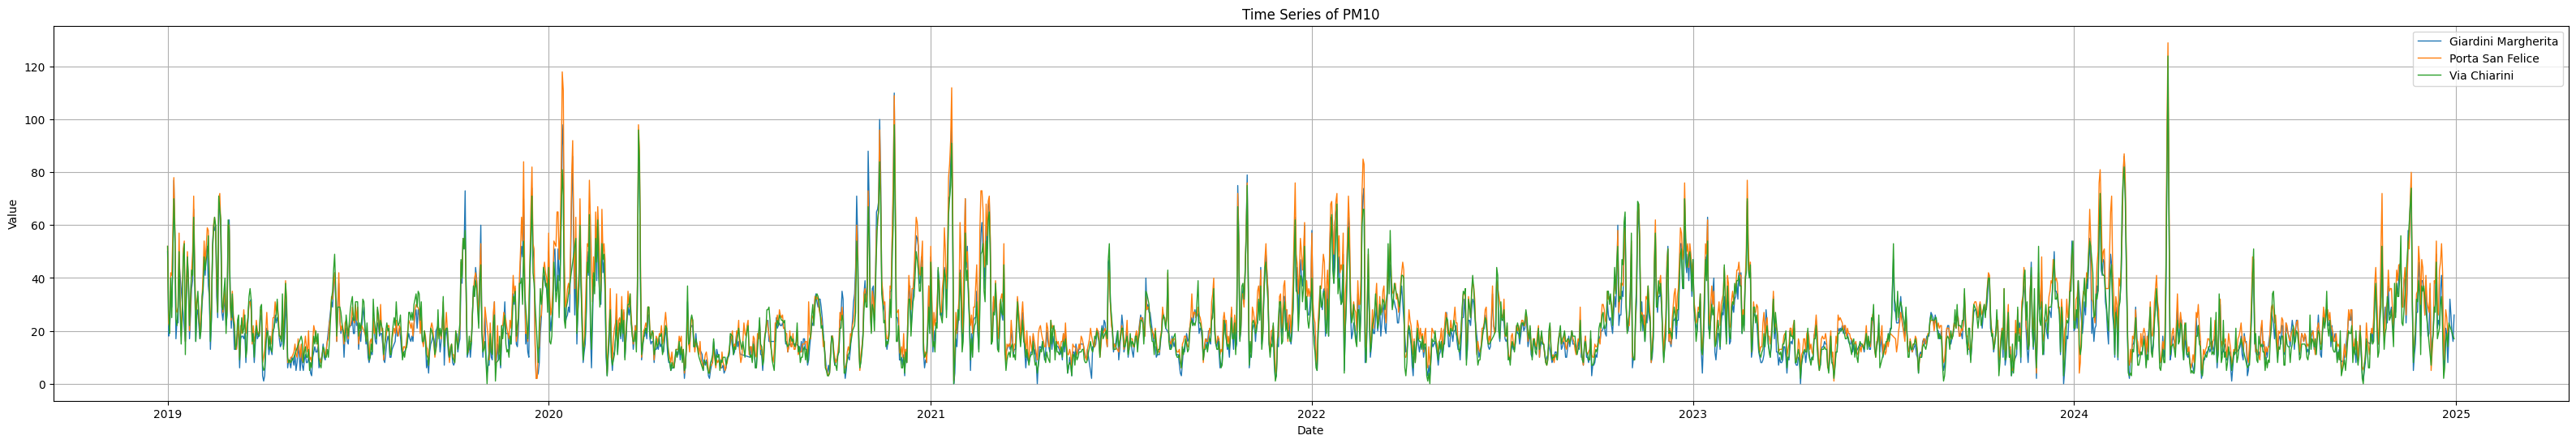

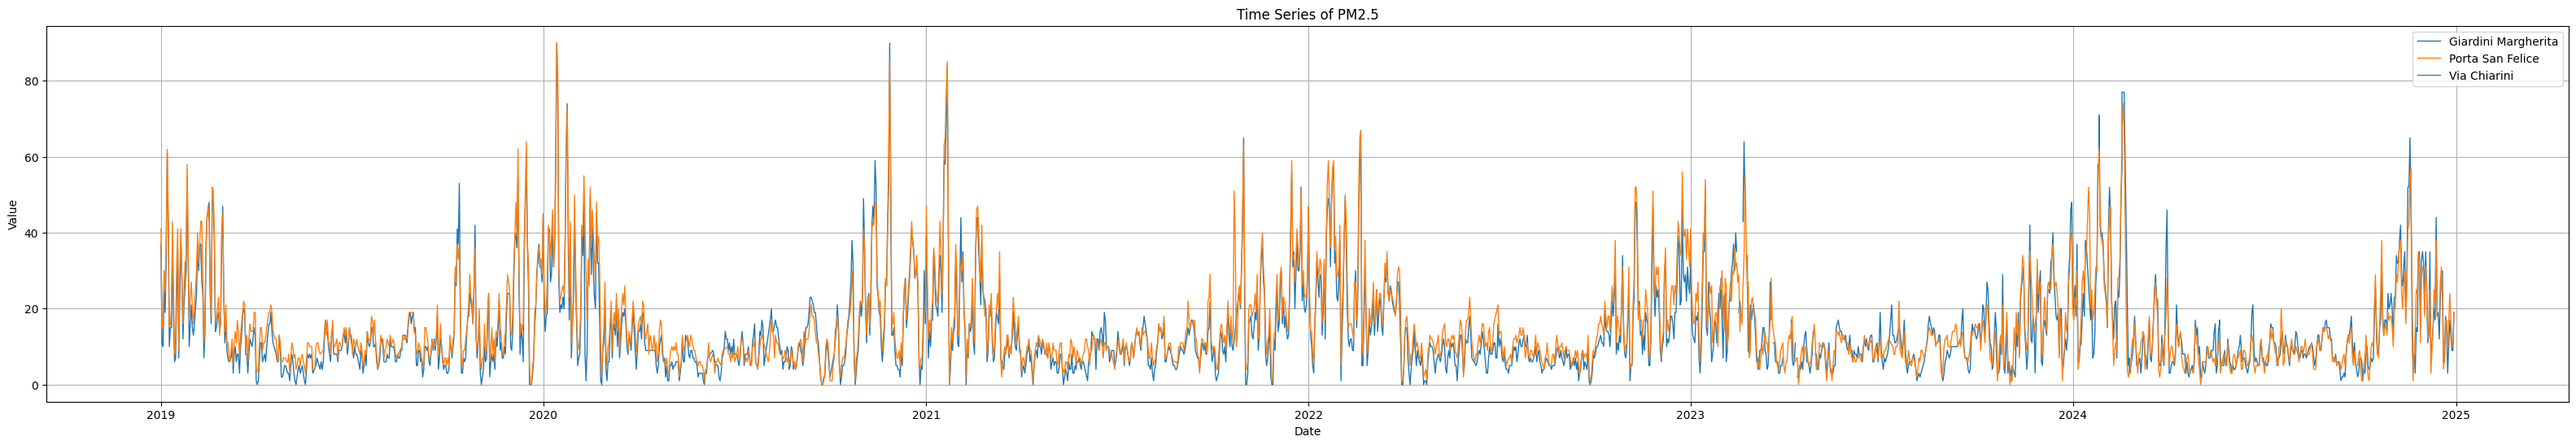

In [5]:
start_date = datetime(2019, 1, 1)
end_date = datetime(2024, 12, 31)

for agent in agents:
    plot_time_series([station_dfs[s][station_dfs[s]['Agent'] == agent] for s in stations], 'Value', None, legends=['Giardini Margherita','Porta San Felice', 'Via Chiarini'], start_date=start_date, end_date=end_date, title=agent)

We can immediately notice the year periodicity for all the agents, showing less polluion during summer.

Agents in common between the stations mostly share the same trend, except for NO2 in Porta San Felice.

## **Missing Values**

Check gaps in the data to inspect how eventual missing values are spreaded. To do so, we can check how many times a certain window of data is missing.

In [6]:
s=stations[0]
print(f'Station {s}:')
for agent in np.unique(station_dfs[s]['Agent']):
    print(f' - Agent: {agent}')
    mask=(station_dfs[s]['Agent']==agent)
    timedeltas_hours = station_dfs[s][mask].index.to_series().diff().dt.total_seconds()[1:] / 3600
    display(pd.DataFrame(timedeltas_hours.value_counts()).transpose())

Station GIARDINI MARGHERITA:
 - Agent: NO2


Date,1.0,2.0,3.0,9.0,0.0,5.0,18.0,4.0,43.0,28.0,...,77.0,50.0,16.0,12.0,11.0,10.0,19.0,8.0,7.0,24.0
count,50984,449,23,4,3,3,2,2,2,1,...,1,1,1,1,1,1,1,1,1,1


 - Agent: O3


Date,1.0,2.0,3.0,4.0,0.0,49.0,8.0,7.0,18.0,10.0,...,17.0,53.0,11.0,84.0,47.0,25.0,51.0,19.0,31.0,43.0
count,51555,134,20,6,6,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1


 - Agent: PM10


Date,24.0,23.0,25.0,48.0,72.0,96.0,144.0,120.0,192.0
count,2038,12,12,12,11,9,3,2,1


 - Agent: PM2.5


Date,24.0,48.0,23.0,25.0,72.0,96.0,0.0,144.0,120.0
count,2071,13,12,12,6,6,5,3,2


In [7]:
s=stations[1]
print(f'Station {s}:')
for agent in np.unique(station_dfs[s]['Agent']):
    print(f' - Agent: {agent}')
    mask=(station_dfs[s]['Agent']==agent)
    timedeltas_hours = station_dfs[s][mask].index.to_series().diff().dt.total_seconds()[1:] / 3600
    display(pd.DataFrame(timedeltas_hours.value_counts()).transpose())

Station PORTA SAN FELICE:
 - Agent: C6H6


Date,1.0,2.0,3.0,4.0,0.0,5.0,25.0,39.0,9.0,8.0,...,22.0,27.0,17.0,97.0,81.0,48.0,43.0,23.0,40.0,20.0
count,46760,1911,193,17,4,4,3,2,2,2,...,1,1,1,1,1,1,1,1,1,1


 - Agent: CO


Date,1.0,2.0,3.0,4.0,0.0,6.0,5.0,8.0,14.0,15.0,...,34.0,17.0,42.0,47.0,11.0,7.0,75.0,22.0,170.0,23.0
count,51678,53,23,5,4,4,3,2,2,2,...,1,1,1,1,1,1,1,1,1,1


 - Agent: NO


Date,1.0,2.0,3.0,4.0,6.0,0.0,5.0,24.0,23.0,19.0,...,15.0,8.0,42.0,7.0,11.0,48.0,18.0,34.0,89.0,16.0
count,51072,410,30,8,7,5,4,3,2,2,...,1,1,1,1,1,1,1,1,1,1


 - Agent: NO2


Date,1.0,2.0,3.0,4.0,5.0,0.0,6.0,14.0,24.0,25.0,...,37.0,15.0,48.0,42.0,18.0,34.0,19.0,23.0,89.0,12.0
count,51070,409,30,8,6,5,5,2,2,2,...,1,1,1,1,1,1,1,1,1,1


 - Agent: NOX


Date,1.0,2.0,3.0,4.0,6.0,0.0,5.0,24.0,15.0,8.0,...,7.0,11.0,18.0,48.0,42.0,34.0,19.0,23.0,89.0,37.0
count,51197,407,31,8,5,5,4,2,1,1,...,1,1,1,1,1,1,1,1,1,1


 - Agent: PM10


Date,24.0,23.0,25.0,48.0,72.0,96.0,144.0,120.0
count,2093,12,12,8,7,5,2,1


 - Agent: PM2.5


Date,24.0,23.0,25.0,48.0,72.0,96.0,120.0,144.0,0.0
count,2094,12,12,11,8,4,1,1,1


In [8]:
s=stations[2]
print(f'Station {s}:')
for agent in np.unique(station_dfs[s]['Agent']):
    print(f' - Agent: {agent}')
    mask=(station_dfs[s]['Agent']==agent)
    timedeltas_hours = station_dfs[s][mask].index.to_series().diff().dt.total_seconds()[1:] / 3600
    display(pd.DataFrame(timedeltas_hours.value_counts()).transpose())

Station VIA CHIARINI:
 - Agent: NO2


Date,1.0,2.0,3.0,4.0,0.0,5.0,7.0,8.0,6.0,12.0,25.0,10.0,21.0,17.0,26.0,31.0,30.0,70.0,39.0,15.0
count,51121,470,28,9,8,6,3,3,3,2,2,1,1,1,1,1,1,1,1,1


 - Agent: O3


Date,1.0,2.0,3.0,4.0,0.0,5.0,8.0,6.0,14.0,7.0,...,28.0,17.0,26.0,13.0,9.0,30.0,70.0,23.0,12.0,25.0
count,51117,386,16,8,6,4,3,2,2,1,...,1,1,1,1,1,1,1,1,1,1


 - Agent: PM10


Date,24.0,48.0,23.0,25.0,72.0,96.0,192.0,120.0,144.0,168.0
count,2065,16,12,12,5,4,2,2,1,1


Some times, multiple consecutive readings are missing.

## **AQI**

Each station collects different data, we decided to treat each station indepentendtely.

Air Quality Index follows this criteria:
- for each pollutant a certain limit is defined (like 25 µg/m³ for PM2.5)
- for each pollutant $ AQI = \frac{Concentration}{Limit} \times 100 $
- take the maximum value across all the IQAs 

The average value is then matched on the following table:

| **AQI**         | **CONDITIONS** |
| --------------- | -------------- |
| <50             | EXCELLENT      |
| From 50 to 99   | GOOD           |
| From 100 to 149   | FAIR           |
| From 150 to 200  | POOR           |
| >200            | VERY POOR      |

We are going to model each agent in order to predict its hour value and then use all of the predictions to compute the overall Air Quality Index and compare it with the one got from the measurements.

In [9]:
categories = {
    'Good': 0,
    'Moderate': 50,
    'Poor': 100,
    'Very Poor': 150,
    'Severe': 200,
}

The limits used are the ones used in Emilia-Romagna.

<table class="pure-table legenda">
    <thead>
        <tr class="main"><th colspan="5">Reference Limits for Monitored Pollutants (Legislative Decree 155/2010)</th></tr>
        <tr>
            <th>Pollutant</th>
            <th>Limit</th>
            <th>Averaging Period</th>
            <th>Limit</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>PM10 (µg/m<sup>3</sup>)</td>
            <td data-column="Limit">Daily limit value</td>
            <td data-column="Averaging Period">Daily average</td>
            <td data-column="Limit">50 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td><abbr title="Nitrogen Dioxide">NO<sub>2</sub></abbr> (µg/m<sup>3</sup>)</td>
            <td data-column="Limit">Hourly limit value</td>
            <td data-column="Averaging Period">Hourly average</td>
            <td data-column="Limit">200 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td rowspan="3"><abbr title="Ozone">O<sub>3</sub></abbr> (µg/m<sup>3</sup>)</td>
            <td data-column="Limit">Information threshold</td>
            <td data-column="Averaging Period">Hourly average</td>
            <td data-column="Limit">180 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td>Alarm threshold</td>
            <td data-column="Averaging Period">Hourly average</td>
            <td data-column="Limit">240 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td>Target value</td>
            <td data-column="Averaging Period">Maximum of 8-hour moving averages</td>
            <td data-column="Limit">120 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td><abbr title="Carbon Monoxide">CO</abbr> (mg/m<sup>3</sup>)</td>
            <td data-column="Limit">Limit value</td>
            <td data-column="Averaging Period">Maximum of 8-hour moving averages</td>
            <td data-column="Limit">10 mg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td><abbr title="Sulfur Dioxide">SO<sub>2</sub></abbr> (µg/m<sup>3</sup>)</td>
            <td data-column="Limit">Daily limit value</td>
            <td data-column="Averaging Period">Daily average</td>
            <td data-column="Limit">125 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td>PM2.5 (µg/m<sup>3</sup>)</td>
            <td data-column="Limit">Annual limit value</td>
            <td data-column="Averaging Period">Daily average</td>
            <td data-column="Limit">25 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td>C6H6 (µg/m<sup>3</sup>)</td>
            <td data-column="Limit">Annual limit value</td>
            <td data-column="Averaging Period">Daily average</td>
            <td data-column="Limit">5 µg/m<sup>3</sup></td>
        </tr>
    </tbody>
</table>

<p><em>Source: <a href="https://apps.arpae.it/qualita-aria/bollettino-qa-provinciale/bo" target="_blank">ARPAE</a></em></p>

*Note that the UMs are already matching the limits, so there is no need for conversion.*

In [10]:
pollutant_limits = {
    'PM2.5': 40,    # µg/m³
    'PM10': 50,     # µg/m³
    'CO': 10,       # mg/m³
    'O3': 120,      # µg/m³
    'NO2': 200,     # µg/m³
    'C6H6': 5       # µg/m³
}

### **Agents**

Let's inspect our agents:

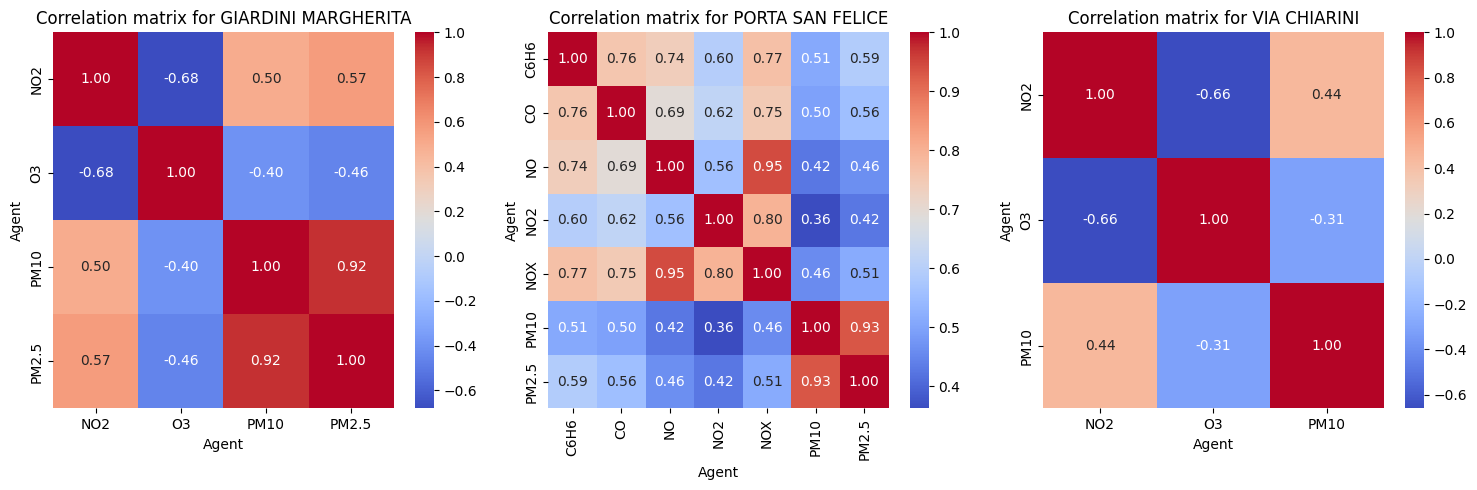

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, s in enumerate(stations):
    corr_matrix = station_dfs[s].pivot_table(index='Date', columns='Agent', values='Value').corr()
    axes[i].set_title(f'Correlation matrix for {s}')
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[i])

plt.tight_layout()
plt.show()

In the AQI standard NO and NOX are not present. NOX is simply a short-hand for both NO and NO2, in facts it is higly correlated with both of them. We can safely drop it since it's not useful and we already have its informations.

Even if NO is different from NO2, it is not used to predict the Air Quality Index, so we choose to ignore it in our models.

In [12]:
for s in stations:
    station_dfs[s] = station_dfs[s][~station_dfs[s]['Agent'].isin(['NO','NOX'])]

PM agents are highly correlated, but both are used in the Air Quality Index, so we keep them.

### **Visualization**

In [13]:
station_dicts = {s:df_to_agents_dict(station_dfs[s].drop(columns=['Unit']), drop_agents=True, drop_stations=True) for s in stations}
for k in station_dicts:
    print(f'Agents in station {k}:',end='\n -')
    print(*list(station_dicts[k].keys()),sep=', ')

Splitting station "GIARDINI MARGHERITA"...
Splitting station "PORTA SAN FELICE"...
Splitting station "VIA CHIARINI"...
Agents in station GIARDINI MARGHERITA:
 -NO2, O3, PM10, PM2.5
Agents in station PORTA SAN FELICE:
 -C6H6, CO, NO2, PM10, PM2.5
Agents in station VIA CHIARINI:
 -NO2, O3, PM10


### **Computation**

For each station construct the daily and hourly AQI for each agent. Then, merge them in a single dataframe using the more present pollutant for each timestep.

The AQI values for each agent is computed using the above table and the provided limits.\
Since that PM2.5 and PM10 AQIs are daily values, we may want to exclude them from the hourly index.

In [14]:
station_AQIs_daily = {
    s: {agent: get_AQI(station_dicts[s][agent], 
                        agent=agent, 
                        period='day', 
                        value_column='Value',
                        limit=pollutant_limits[agent], 
                        ) for agent in station_dicts[s].keys()} for s in station_dicts
}
station_AQI_daily = merge_AQIs(station_AQIs_daily, period='day')

station_AQIs_hourly = {
    s: {agent: get_AQI(station_dicts[s][agent],
                       agent=agent,
                       period='hour', 
                       value_column='Value',
                       limit=pollutant_limits[agent],
                       include_hourly_pm=False
                       ) for agent in station_dicts[s].keys()} for s in station_dicts
}
station_AQI_hourly = merge_AQIs(station_AQIs_hourly, period='hour')

We can now plot the Air Quality Index, colored using the agent resulting in the higher index, and displaying the categories limits.

Station GIARDINI MARGHERITA AQI:


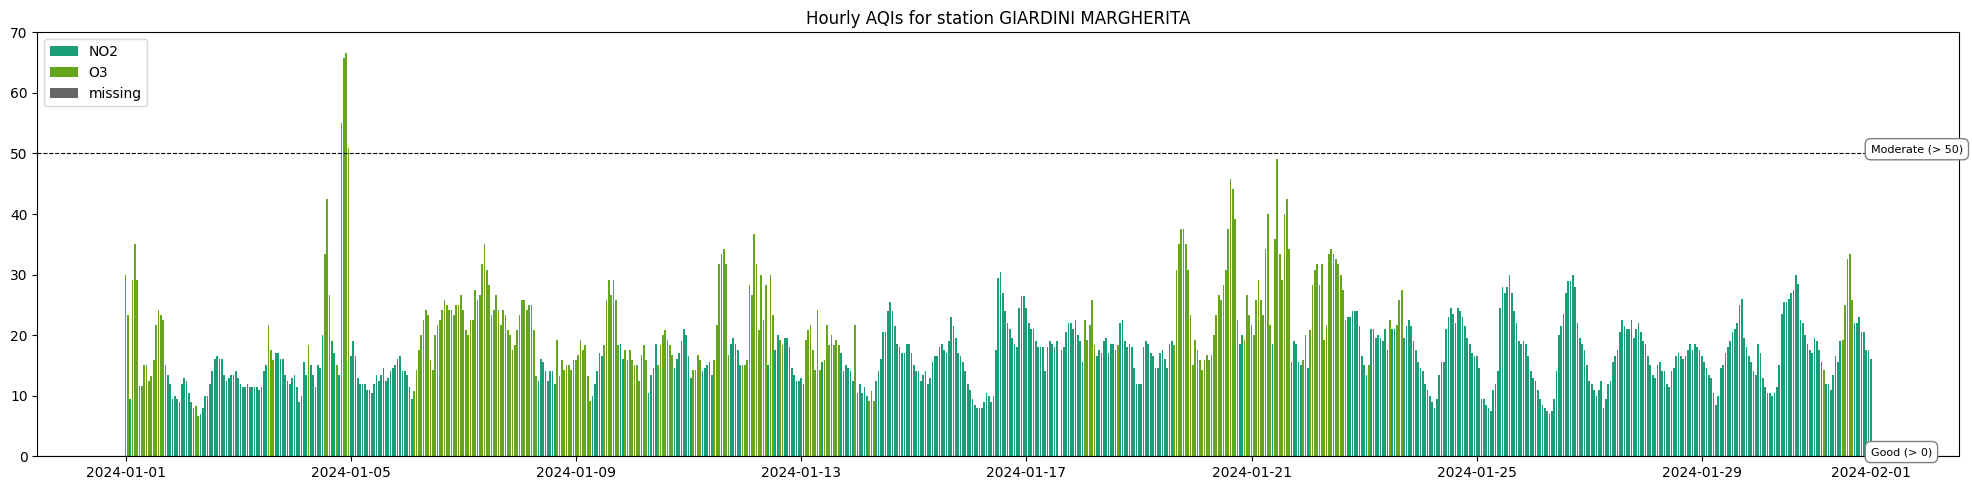

Station PORTA SAN FELICE AQI:


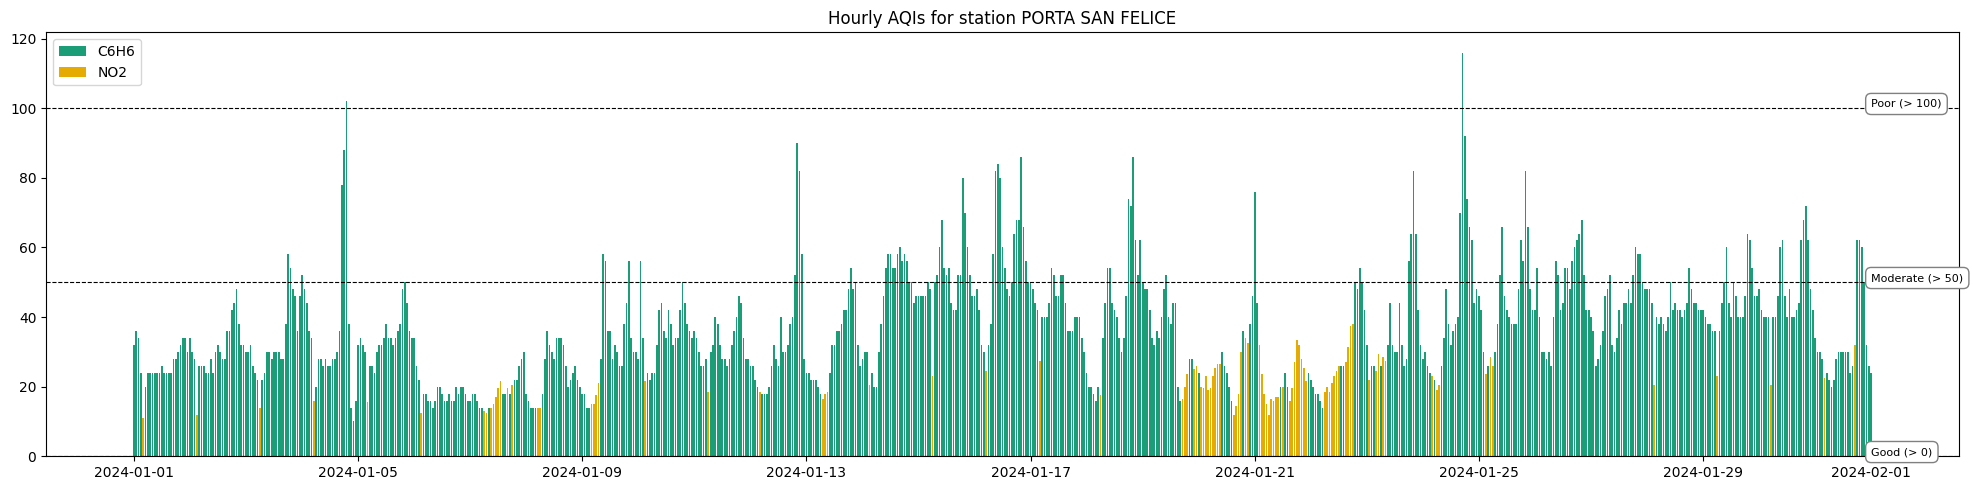

Station VIA CHIARINI AQI:


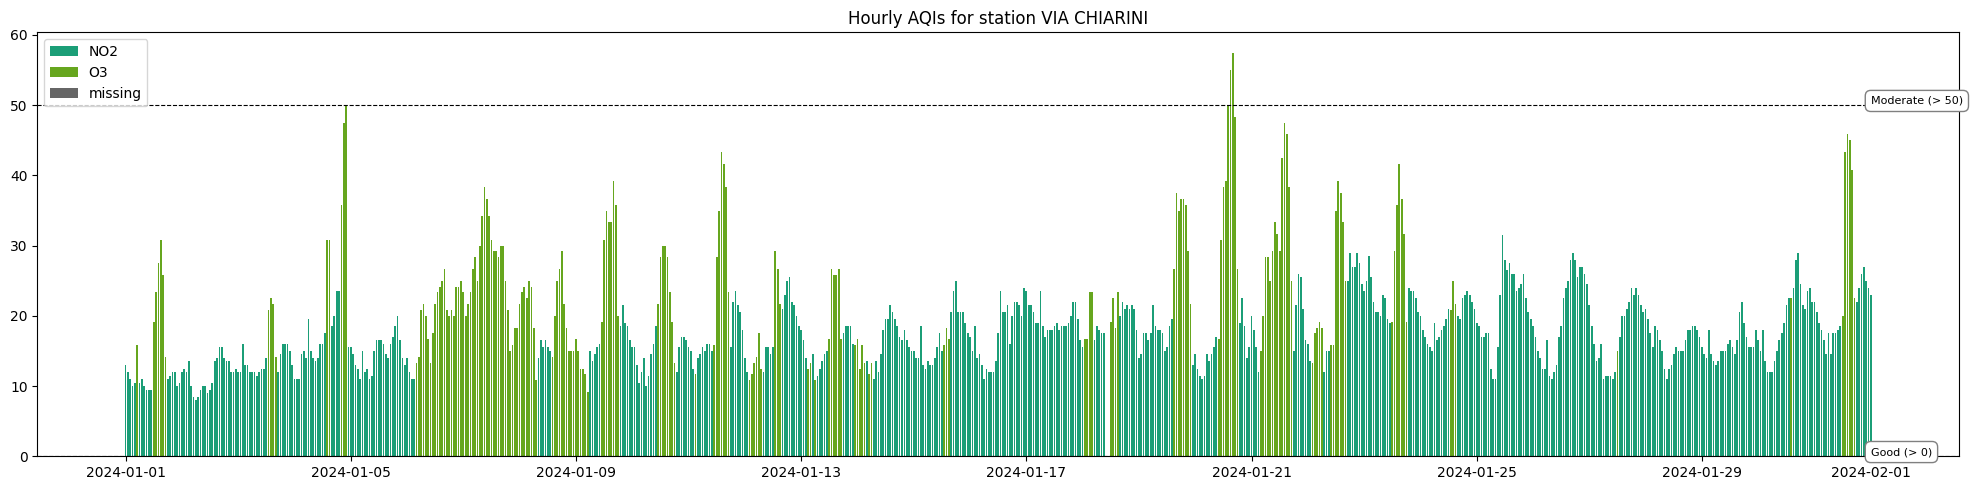

In [15]:
start=datetime(2024,1,1)
end=datetime(2024,2,1)

for station in station_AQIs_hourly:
    print(f'Station {station} AQI:')

    plot_AQI(
        station_AQI=[
            station_AQI_hourly[station],
        ], 
        title=[
            f'Hourly AQIs for station {station}',
        ],
        categories=categories,
        figsize=(20, 5), s=start, e=end)

Hourly AQI is mostly on the lowest risk category... 

Station GIARDINI MARGHERITA AQI:


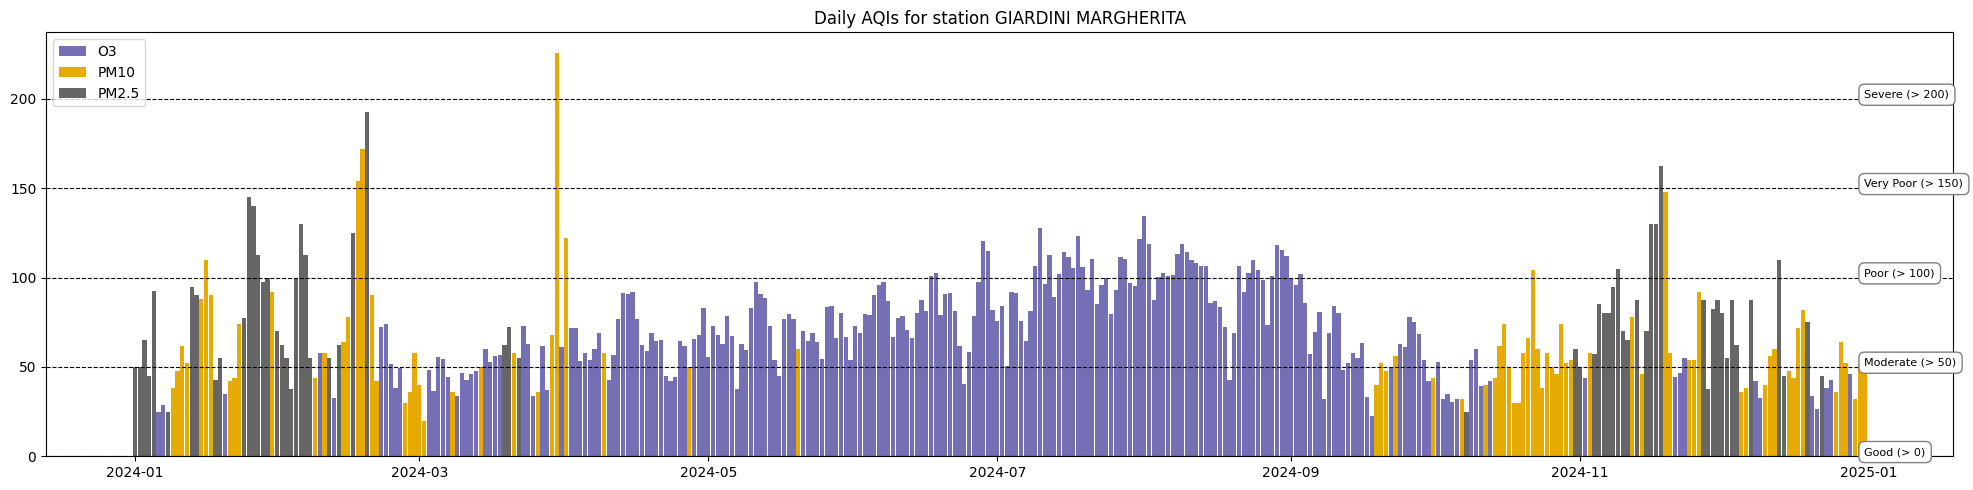

Station PORTA SAN FELICE AQI:


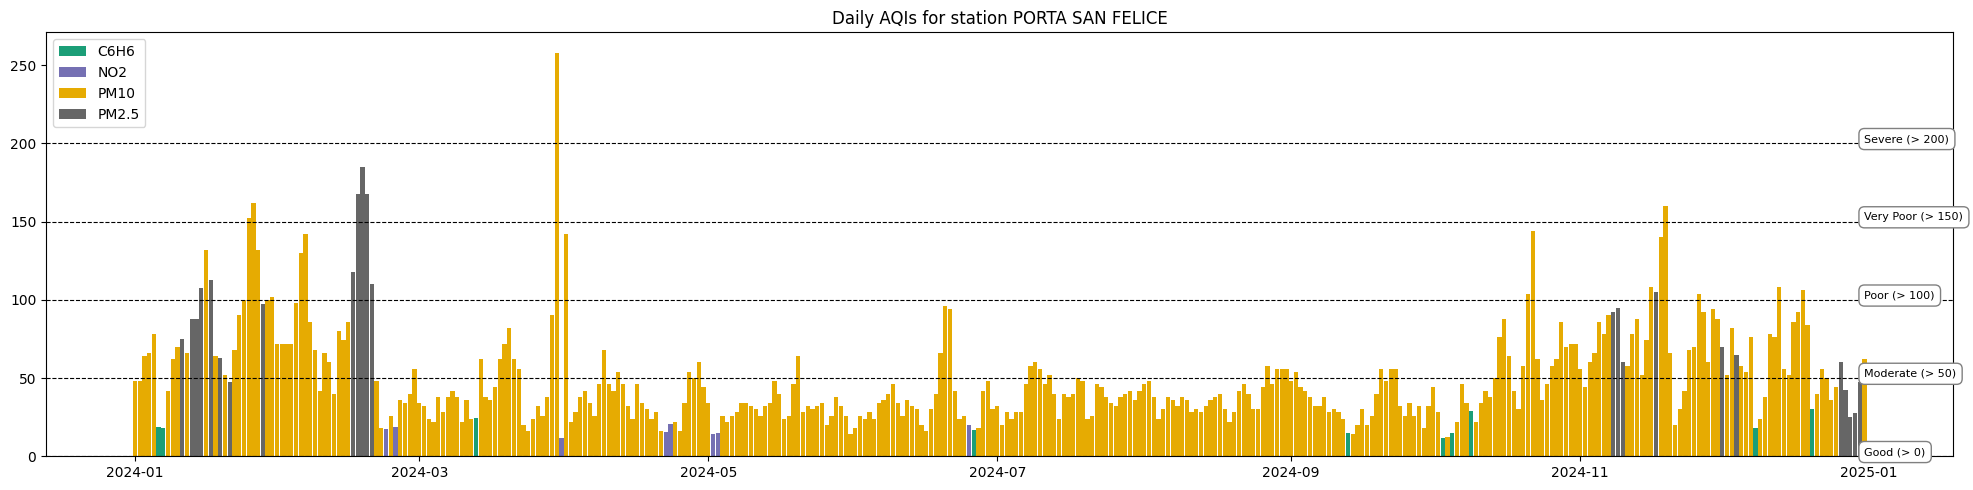

Station VIA CHIARINI AQI:


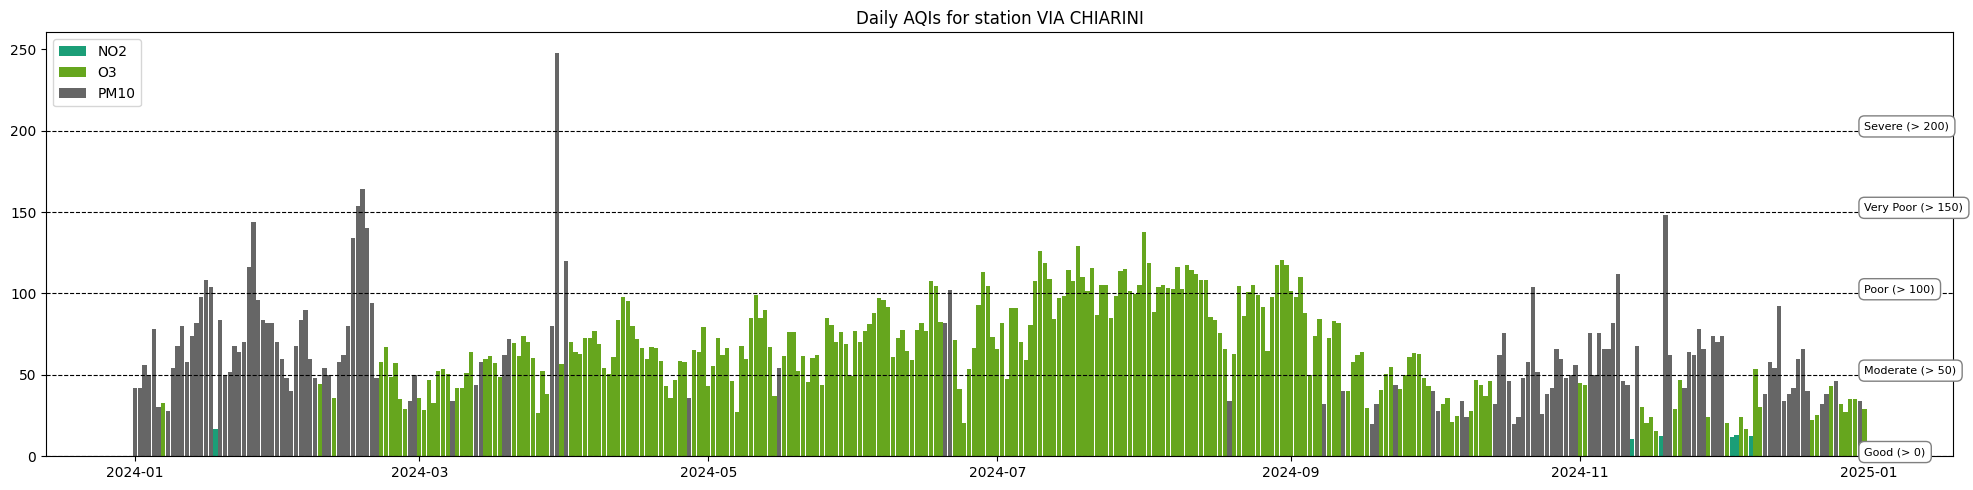

In [16]:
start=datetime(2024,1,1)
end=datetime(2024,12,31)

for station in station_AQIs_daily:
    print(f'Station {station} AQI:')

    plot_AQI(
        station_AQI=[
            station_AQI_daily[station],
        ], 
        title=[
            f'Daily AQIs for station {station}',
        ],
        categories=categories,
        figsize=(20, 5), s=start, e=end)

The AQIs between the stations share a similar behaviour, except for Porta San Felice that is missing O3, relevant during the summer.